In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from thinkdsp import *
import os
from tqdm.notebook import tqdm
import multiprocessing as mp
plt.ioff()

In [ ]:
with tf.device('/cpu'):
    model = tf.keras.models.load_model('my_model', compile=False)


Here I use an adversarial attack to fool the model. Motivation - adversarial attacks are a powerful and simple tool to fool neural networks which has good coverage in the literature and has been widely used by practioners. 

It will be a white-box attack since we have direct access to the model. However, there is a non-differentiable module for construction of a spectrogram. That makes the conventional strategy for generation of adversarial attacks difficult. Fortunately, there is still a way which is described in this paper: https://arxiv.org/pdf/1802.00420.pdf. In short, I will do a usual forward pass with non-differentiable STFT. However, I will also construct a differentiable STFT function and use it during backward pass. In this way, it is possible to pass the gradients to the input.

In [ ]:
def tf_stft(x, y):
    # Ensure correct shape
    x = tf.squeeze(x, axis=-1)

    # Create a Spetrogram
    stft = tf.signal.stft(x, 
                          frame_length=1024, frame_step=512,
                          window_fn=tf.signal.hamming_window)
    # Take the same range of frequencies as in the pretrained model
    stft = stft[:, :, :int(stft.shape[2] * 5000 / (x.shape[1] // 2))]
    stft = tf.math.abs(stft)
    # Resize to the same shape as the input to the pretrained model
    stft = tf.repeat(stft, 16, axis=1)
    stft = tf.transpose(stft, perm=[2,1,0])[::-1]
    stft = tf.image.resize(stft, (369, 496))
    stft = tf.transpose(stft, perm=[2,0,1])

    # To 3-channel image (again, the same as the input to the pretrained model)
    stft = tf.expand_dims(stft, -1)
    stft = tf.image.grayscale_to_rgb(stft)
    
    return stft, tf.one_hot(y, 8)

def get_test_ds():
    test_ds = tf.keras.utils.audio_dataset_from_directory(
        directory='test_audio',
        batch_size=1,
        seed=0,
        output_sequence_length=16000,
        )
    return test_ds

In [ ]:
test_ds = get_test_ds()

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
def non_diff_spec(x):
    wave = Wave(ys=x.numpy().flatten(), framerate=16000)
    wave.make_spectrogram(1024).plot(high=5000)

    plt.axis('off')
    plt.savefig('loh.png', bbox_inches='tight', pad_inches=0)
    plt.clf()
    with Image.open('loh.png') as img:
        img = np.asarray(img)[None, :,:,:3]
        
    return tf.convert_to_tensor(img, dtype=tf.float32) / 255.

In [7]:
def helper_quit(x, y):
    pred = model(non_diff_spec(x))
    pred_cls = tf.math.argmax(pred[0]).numpy()
    
    return pred_cls != y

def gen_adv(x_, y, max_frac=.15, eps=1e-2):
    """
    Procedure for the attack is described in this paper:
    https://arxiv.org/pdf/1802.00420.pdf
    """
    x = tf.Variable(tf.identity(x_))
    y = y[0].numpy()
    
    # If the model already classifies this sample incorrectly - skip it
    if helper_quit(x, y):
        return x, None
    # Otherwise, start to generate an adversarial example
    # constraint on amount of entries that I can change
    slice_ = int(x.shape[1] * max_frac)
    optimizer = tf.keras.optimizers.Adam()
    history = []
    for i in range(25):
        with tf.GradientTape() as input_tape:
            input_tape.watch(x)
            # Differentiable stft
            stft_x, _ = tf_stft(x, y)

        # Non-differentiable stft 
        spec = non_diff_spec(x)
        with tf.GradientTape() as spec_tape:
            spec_tape.watch(spec)
            pred = model(spec)
            
            cls = pred[0, y]
            loss = pred[0, y]

        # Calculate gradient w.r.t. the spectrogram
        grad = spec_tape.gradient(loss, spec)
        # Forward this gradient to the audio input
        grad = input_tape.gradient(stft_x, x, 
                                   output_gradients=-grad)
        # I will change only first 15% of entries
        # Thus, I will take only top 15% of grad values with largest magnitudes
        # Other values of delta are zeroed out.
        if i == 0:
            # These indices should be changed only on the first iteration
            # and reused in the following ones.
            values, top_indices = tf.math.top_k(tf.squeeze(grad, axis=-1), k=slice_)
            
        delta_ = tf.scatter_nd(indices=tf.expand_dims(top_indices[0], axis=-1), 
                              updates=tf.gather(grad[0, :, 0], indices=top_indices[0]),
                              shape=tf.constant([grad.shape[1]]))
        delta_ = tf.expand_dims(delta_, axis=0)
        delta_ = tf.expand_dims(delta_, axis=-1)
        history.append(tf.math.reduce_mean(delta_[delta_ != 0]).numpy())
        
        optimizer.apply_gradients([(delta_, x)])
        
    return x, tf.math.argmax(pred[0])


In [24]:
for x, y in test_ds:
    break

In [25]:
with tf.device('cpu'):
    adv_x, cls = gen_adv(x,y)

In [26]:
(x == adv_x).numpy().sum()


13600

In [27]:
test_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

Here is a visualization of my attack. The resulting audio is almost indistiguishable from the original wave. Nevertheless, the model produces a different class with high confidence.

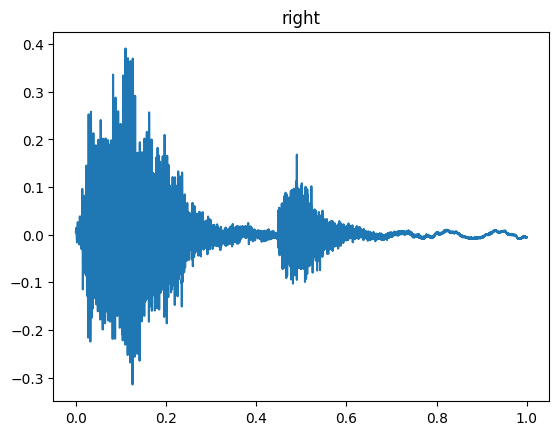

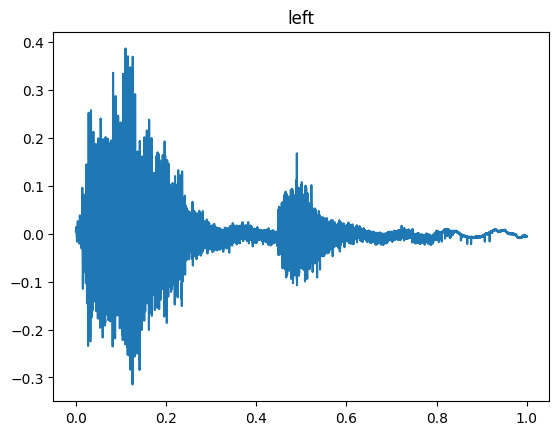

In [28]:
org_wave = Wave(ys=x[0,:,0].numpy(), framerate=16000)
# org_cls = test_ds.class_names[tf.math.argmax(model(tf_stft(x, y)[0])[0]).numpy()]
org_cls = test_ds.class_names[y[0]]
# print(org_cls)
org_wave.plot()
plt.title(str(org_cls))
plt.show()
display(org_wave.make_audio())
adv_wave = Wave(ys=adv_x[0,:,0].numpy(), framerate=16000)
adv_cls = tf.math.argmax(model(non_diff_spec(adv_x))[0]).numpy()
adv_cls = test_ds.class_names[adv_cls]
# print(adv_cls)
adv_wave.plot()
plt.title(str(adv_cls))
plt.show()
display(adv_wave.make_audio())

In [8]:
def gen_adv_and_dump(ixy):
    i, (x, y) = ixy
    
    with tf.device('cpu'):
        adv_x, cls = gen_adv(x,y)
        
    adv_wave = Wave(ys=adv_x[0,:,0].numpy(), framerate=16000)
    
    # Save augmented audio
    adv_audio_path = os.path.join(
            'adv_audio',
            test_ds.class_names[y[0]],
            f'{i}.wav'
    )
    os.makedirs(os.path.dirname(adv_audio_path), exist_ok=True)
    
    WavFileWriter(filename=adv_audio_path, framerate=adv_wave.framerate).write(adv_wave)
    
    if cls is not None:
        return y[0].numpy(), cls.numpy()
    else:
        return None, None

Here I'll generate an adversarial sample for each sample in the dataset.

In [10]:
# Load data
test_ds = get_test_ds()

# Generate adversarial examples
# with mp.Pool() as pool:

outs = []
try:
    for s in tqdm(enumerate(test_ds), total=len(test_ds)):
        out = gen_adv_and_dump(s)
        outs.append(out)
except KeyboardInterrupt:
    pass

ys, adv_ys = zip(*outs)
# Transform them to arrays and choose only labels for adversarial samples
ys = np.asarray(ys, dtype=np.float32)
ys = ys[~np.isnan(ys)]
adv_ys = np.asarray(adv_ys, dtype=np.float32)
adv_ys = adv_ys[~np.isnan(adv_ys)]

Found 1599 files belonging to 8 classes.


  0%|          | 0/1599 [00:00<?, ?it/s]

/tf/thinkdsp.py:1173: UserWarning: Warning: normalizing before quantizing.
  warnings.warn("Warning: normalizing before quantizing.")


Attack's success rate

In [11]:
np.sum(ys != adv_ys) / len(ys)

0.6742081447963801

Here I'll generate spectrograms for each adversarial sample and will dump them to the disk.

In [12]:
import re

def rename(path):
    path = re.sub(r'adv_audio', 'adv_spec', path)
    path = re.sub(r'wav$', 'png', path)
    
    return path

def wav_to_png(path):
    wave = read_wave(path)
    spectrogram = wave.make_spectrogram(seg_length=1024)
    spectrogram.plot(high=5000)

    # Save spectrogram
    plt.axis('off')
    png_path = rename(path)
    os.makedirs(os.path.dirname(png_path), exist_ok=True)
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0)

In [13]:
from pathlib import Path
import multiprocessing as mp

wavs = list(map(str, Path('adv_audio').rglob('*.wav')))


In [14]:

with mp.Pool() as pool:
    pool.map(wav_to_png, tqdm(wavs))

  0%|          | 0/1599 [00:00<?, ?it/s]

Now, let's evaluate the model performance on adversarial samples. Model performanced has dropped by 40% - very good attack strategy.

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
IMAGE_SHAPE = (369, 496)
VALID_DATA_DIR = 'test_spec/' # replace with your generated test set in here
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

with tf.device('cpu'):
    model = keras.models.load_model('my_model', compile=False)
    model.compile(
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.evaluate(valid_generator)

Found 1600 images belonging to 8 classes.
50/50 [==============================] - 13s 247ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.6906


In [3]:
IMAGE_SHAPE = (369, 496)
VALID_DATA_DIR = 'adv_spec/' # replace with your generated test set in here
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

with tf.device('cpu'):
    model = keras.models.load_model('my_model', compile=False)
    model.compile(
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.evaluate(valid_generator)

Found 1599 images belonging to 8 classes.
50/50 [==============================] - 12s 238ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.2183
